**PREDICTING HOTEL BOOKING CANCELLATIONS IN PYTHON USING PIPELINES**


In this notebook ,we will build a machine learning model to predict whether or not a customer cancelled a hotel booking.

We will use a fairly general dataset, this dataset is also available on Kaggle.


Have you ever wondered when the best time of year to book a hotel room is? 
Or the optimal length of stay in order to get the best daily rate? 

What if you wanted to predict whether or not a hotel was likely to receive a 
disproportionately high number of special requests?


This data set is ideal for anyone looking to practice their exploratory data analysis (EDA) or get started in building predictive models!

If you're looking for inspiration on data visualizations, check out the #TidyTuesday program, a free, weekly online event that encourages participants to create and share their code and visualizations for a given data set on Twitter.

This data set contains a single file which compares various booking information between two hotels: a city hotel and a resort hotel.

In [6]:
#Data imports
import pandas as pd
import numpy as np
#Visualization imports
import plotly.express as px
#ML Imports and Configuration
from sklearn.model_selection import train_test_split,KFold,cross_validate,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
set_config(display="diagram")


In [51]:
hotel_bookings=pd.read_csv('C:\\Users\\shash\\Downloads\\hotel_cleaned.csv')
#hotel_bookings=pd.read_csv('C:\\Users\\shash\\OneDrive\\Documents\\hotel_bookings.csv')
hotel_bookings.head()

,Unnamed: 0,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,booking_changes,deposit_type,agent,customer_type,adr,total_of_special_requests,reservation_status,reservation_month,reservation_dayofWeek,reservation_year
0,7,0,0,9,2015,7,27,1,0,2,...,0,No Deposit,303.0,Transient,103.00,1,Check-Out,7,4,2015
1,9,0,1,75,2015,7,27,1,0,3,...,0,No Deposit,15.0,Transient,105.50,0,Canceled,4,2,2015
2,10,0,1,23,2015,7,27,1,0,4,...,0,No Deposit,240.0,Transient,123.00,0,Canceled,6,1,2015
3,11,0,0,35,2015,7,27,1,0,4,...,0,No Deposit,240.0,Transient,145.00,0,Check-Out,7,6,2015
4,13,0,0,18,2015,7,27,1,0,4,...,1,No Deposit,241.0,Transient,154.77,1,Check-Out,7,6,2015


In [52]:
bookings_by_month=hotel_bookings.groupby('arrival_date_month',as_index=False)[['hotel']].count()
bookings_by_month

,arrival_date_month,hotel
0,1,530
1,2,890
2,3,1605
3,4,3507
4,5,4277
5,6,4595
6,7,6623
7,8,7903
8,9,3326
9,10,2294


In [53]:
bookings_by_month=hotel_bookings.groupby('arrival_date_month',as_index=False)[['hotel']].count().rename(columns={'hotel':'nb_bookings'})
months=['January','February','March','April','May','June','July','August','September','October','November','December']
fig=px.bar(
bookings_by_month,
x='arrival_date_month',
y='nb_bookings',
title=f'Hotel_Bookings_By_Month',
category_orders={"arrival_date_month":months})
fig.show(config={"displayModeBar":False})

**1.SPLIT THE DATA INTO TRAINING AND TEST SETS**

Let us start by defining the data into training and test sets.

The basic idea is to train the model on a test its performance oon the other portion that has not been seen by the model 
This done to prevent overfitting.

In [33]:
features_num=["hotel","lead_time","arrival_date_year","arrival_date_month","arrival_date_week_number","arrival_date_day_of_month","stays_in_weekend_nights",
             "stays_in_week_nights","booking_changes","agent","adr","total_of_special_requests","reservation_month","reservation_dayofWeek","reservation_year"]
features_cat=["deposit_type","customer_type","reservation_status"]
features=features_num+features_cat
X=hotel_bookings[features]
y=hotel_bookings["is_canceled"]
X_train,X_test,y_train,y_test =train_test_split( X,y , test_size=0.4,random_state=420)

**2.PREPROCESS THE DATA** 

The next step is to setup a pipeline to preprocess the features
We will impute all missing values with a constant,and one-hot encode all categorical features

In [34]:
transformer_num=SimpleImputer(strategy='constant')
transformer_cat=Pipeline(steps=[("imputer",SimpleImputer(strategy="constant",fill_value="Unknown")),
                                ("onehot",OneHotEncoder(handle_unknown='ignore'))])
preprocessor=ColumnTransformer(transformers=
                               [("num",transformer_num,features_num),
                                ("cat",transformer_cat,features_cat)
                               ])
preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['hotel', 'lead_time', 'arrival_date_year',
                                  'arrival_date_month',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'booking_changes',
                                  'agent', 'adr', 'total_of_special_requests',
                                  'reservation_month', 'reservation_dayofWeek',
                                  'reservation_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['deposit_type', 'customer_type',
                                  'reservation_status'])])

**3.FIT THE MODELS AND EVALUATE PERFORMANCE**

Next,we extend the pipleine to fit a Decision Tree model on the training data.

In [55]:
steps=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',DecisionTreeClassifier(random_state=1234))
])
steps.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['hotel', 'lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_month',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'booking_changes', 'agent',
                                                   'adr',
                                                   'total_of_special_requests',
                                                   'reservation_month',
                                                   'reservation_dayofWeek',
                                                   'reservation_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['deposit_type',
                                                   'customer_type',
                                                   'reservation_status'])])),
                ('model', DecisionTreeClassifier(random_state=1234))])

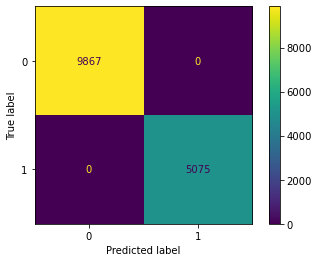

In [56]:
plot_confusion_matrix(steps,X_test,y_test)

In [41]:
y_pred=steps.predict(X_test)
acc=accuracy_score(y_test,y_pred)
print(acc)
conf=confusion_matrix(y_test,y_pred)
print(conf)

1.0
[[9867    0]
 [   0 5075]]


**The END** 



With this trained pipeline ,we can now predict whether or not a new previously unseen booking will
be canceled with an accurcy of roughly 100%,this can be useful in planning room availability whic gusts are at risk 
of cancelling their booking to take corrective action.

**This model is a pretty hypothetical model as in majority of the cases the model is not perfectly accurate.**